In [1]:
import pandas as pd
import os
import json
from bs4 import BeautifulSoup

DATA_DIR = '../data/google-natural-questions/'

def count_words(text):
    return len(text.split())

def html_to_text(html_content):
    soup = BeautifulSoup(html_content, 'html5lib') # for malformed html
    text = soup.get_text(separator=' ')
    text = text.strip()
    return text

def process_entry(entry):
    question_text = entry.get("question_text", "")
    example_id = entry.get("example_id", "")
    document_text = entry.get("document_text", "")
    annotations = entry.get("annotations", [])
    
    long_answers = []
    long_answers_cleaned = []
    short_answers = set()
    
    for annotation in annotations:
        long_answer = annotation.get("long_answer", {}).get("text", "")
        if long_answer:
            long_answers.append(long_answer)
            long_answers_cleaned.append(html_to_text(long_answer))
        
        for short_answer in annotation.get("short_answers", []):
            short_answers.add(short_answer.get("text", ""))
    
    return {
        "ExampleId": example_id,
        "QuestionText": question_text,
        "DocumentText": document_text,
        "LongAnswers": long_answers,
        "LongAnswersCleaned": long_answers_cleaned,
        "ShortAnswers": list(short_answers)
    }

try:
    print('Trying to load data')
    df = pd.read_csv(os.path.join(DATA_DIR, 'google-natural-questions-structured.csv'))
    print('Data already processed')
except:
    print('Data not processed yet')
    file_names = ['simplified-nq-dev.jsonl', 'simplified-nq-train.jsonl']
    data_list = []
    for file_name in file_names:
        file_path = os.path.join(DATA_DIR, file_name)
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line.strip())
                data_list.append(process_entry(entry))
    df = pd.DataFrame(data_list)
    df.to_csv(os.path.join(DATA_DIR, 'google-natural-questions-structured.csv'), index=False)

df

Trying to load data
Data already processed


,ExampleId,QuestionText,DocumentText,LongAnswers,LongAnswersCleaned,ShortAnswers,QuestionLength,NumContexts,ContextLength,LongAnswerLength,LongAnswerCleanedLength,ShortAnswerCount
0,-6570496346595660652,what are the main crops grown in the united st...,Agriculture in the United States - wikipedia <...,['<Table> <Tr> <Th> Major Crops in the USA </T...,['Major Crops in the USA 1997 ( in US $ bi...,"['Rice', 'Cotton', 'Wheat', 'Tobacco', 'Soybea...",10,46,12329,1000,366,11
1,7811140318762480311,who is the owner of the mandalay bay in vegas,Mandalay Bay - wikipedia <H1> Mandalay Bay </H...,"[""<P> Mandalay Bay is a 43 - story luxury reso...","[""Mandalay Bay is a 43 - story luxury resort a...",['MGM Resorts International'],10,23,6561,532,426,1
2,-472523896331012000,which of the following was not one of the func...,Freedmen 's Bureau - wikipedia <H1> Freedmen '...,[],[],[],14,47,12050,0,0,0
3,5159516459824335717,get back get back you don't know me like that ...,Get Back ( Ludacris song ) - Wikipedia <H1> Ge...,[],[],[],11,6,2618,0,0,0
4,4111902318448915849,who was the first nominated lady for rajya sabha,List of nominated members of Rajya Sabha - wik...,['<Table> <Tr> <Th> No . </Th> <Th> Name </Th>...,['No . Name Field Affiliation ...,[],9,3,3039,380,196,0
...,...,...,...,...,...,...,...,...,...,...,...,...
315198,-4860763920664935992,when does sam malone get his bar back,Sam Malone - Wikipedia <H1> Sam Malone </H1> J...,[],[],[],8,31,7219,0,0,0
315199,5733276129126234955,who has been eliminated on big brother 17,Big Brother 19 ( U.S. ) - wikipedia <H1> Big B...,[],[],[],8,41,18817,0,0,0
315200,-2176841346641996646,whoop whoop that's the sound of da police,Sound of da police - wikipedia <H1> Sound of d...,[],[],[],8,4,1500,0,0,0
315201,5821082858248975115,whats the difference between mexican and spani...,Chorizo - wikipedia <H1> Chorizo </H1> Jump to...,[],[],[],8,35,5913,0,0,0


In [2]:
num_questions = df.shape[0]

df['QuestionLength'] = df['QuestionText'].apply(count_words)
avg_question_length = df['QuestionLength'].mean()
std_question_length = df['QuestionLength'].std()

df['NumContexts'] = df['DocumentText'].apply(lambda x: x.count('<P>'))
num_contexts = df['NumContexts'].sum()

df['ContextLength'] = df['DocumentText'].apply(count_words)
avg_context_length = df['ContextLength'].mean()
std_context_length = df['ContextLength'].std()

df['LongAnswerLength'] = df['LongAnswers'].apply(lambda x: sum(count_words(answer) for answer in x))
df['LongAnswerCleanedLength'] = df['LongAnswersCleaned'].apply(lambda x: sum(count_words(answer) for answer in x))
df['ShortAnswerCount'] = df['ShortAnswers'].apply(len)

avg_answer_length = df['LongAnswerLength'].mean()
std_answer_length = df['LongAnswerLength'].std()

avg_answer_cleaned_length = df['LongAnswerCleanedLength'].mean()
std_answer_cleaned_length = df['LongAnswerCleanedLength'].std()

avg_short_answer_count = df['ShortAnswerCount'].mean()
std_short_answer_count = df['ShortAnswerCount'].std()


print(f"Number of questions: {num_questions}")
print(f"Average question length: {avg_question_length:.2f} words")
print(f"Standard deviation of question length: {std_question_length:.2f} words")
print(f"Number of contexts (facts): {num_contexts}")
print(f"Average context length: {avg_context_length:.2f} words")
print(f"Standard deviation of context length: {std_context_length:.2f} words")
print(f"Average long answer length: {avg_answer_length:.2f} words")
print(f"Standard deviation of long answer length: {std_answer_length:.2f} words")
print(f"Average cleaned long answer length: {avg_answer_cleaned_length:.2f} words")
print(f"Standard deviation of cleaned long answer length: {std_answer_cleaned_length:.2f} words")
print(f"Average number of short answers: {avg_short_answer_count:.2f}")
print(f"Standard deviation of number of short answers: {std_short_answer_count:.2f}")

Number of questions: 315203
Average question length: 9.24 words
Standard deviation of question length: 1.83 words
Number of contexts (facts): 11266272
Average context length: 8992.81 words
Standard deviation of context length: 8245.76 words
Average long answer length: 908.10 words
Standard deviation of long answer length: 5548.32 words
Average cleaned long answer length: 616.05 words
Standard deviation of cleaned long answer length: 3516.09 words
Average number of short answers: 13.15
Standard deviation of number of short answers: 30.06


In [3]:
import sys
import os

module_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib.ngrams import process_ngrams

questions = df['QuestionText'].tolist()

if os.path.isfile(os.path.join(DATA_DIR, 'ngrams-sorted.csv')):
    df_ngram = pd.read_csv(os.path.join(DATA_DIR, 'ngrams-sorted.csv'))
else: 
    df_ngram = process_ngrams(questions, range(1, 9))
    df_ngram.to_csv(os.path.join(DATA_DIR, 'ngrams-sorted.csv'), index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/yuehengzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing n-grams:   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
import pandas as pd
from lib.ngrams import calculate_ratios

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

n_values = list(range(1, 9))
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

ratios, top_1_percent_ratios, total_counts = calculate_ratios(df_ngram, n_values, k_values)

ratios['Top 1%'] = top_1_percent_ratios
ratios['Total Count'] = total_counts

print("GoogleNQ n-gram Ratios:")
print(pd.DataFrame(ratios, index=[f'{n}-gram' for n in n_values]))

GoogleNQ n-gram Ratios:
               1         2         4         8        16        32        64       128       256    Top 1%  Total Count
1-gram  0.092111  0.133840  0.198445  0.271215  0.353704  0.424052  0.494754  0.560738  0.627460  0.716499        61320
2-gram  0.014057  0.027491  0.048322  0.071166  0.098360  0.133323  0.175004  0.213036  0.253828  0.499465       548362
3-gram  0.007204  0.010296  0.016198  0.024316  0.036313  0.049997  0.065734  0.083074  0.103670  0.302922      1084499
4-gram  0.001791  0.003268  0.005438  0.008114  0.012654  0.018435  0.025229  0.033678  0.044951  0.181039      1340747
5-gram  0.001509  0.002304  0.003771  0.005912  0.008032  0.010542  0.014194  0.019049  0.025266  0.111131      1353384
6-gram  0.000627  0.001206  0.001924  0.002655  0.003779  0.005346  0.007410  0.010140  0.013549  0.068569      1217421
7-gram  0.000270  0.000469  0.000759  0.001115  0.001641  0.002339  0.003263  0.004594  0.006529  0.043177       992926
8-gram  0.000263

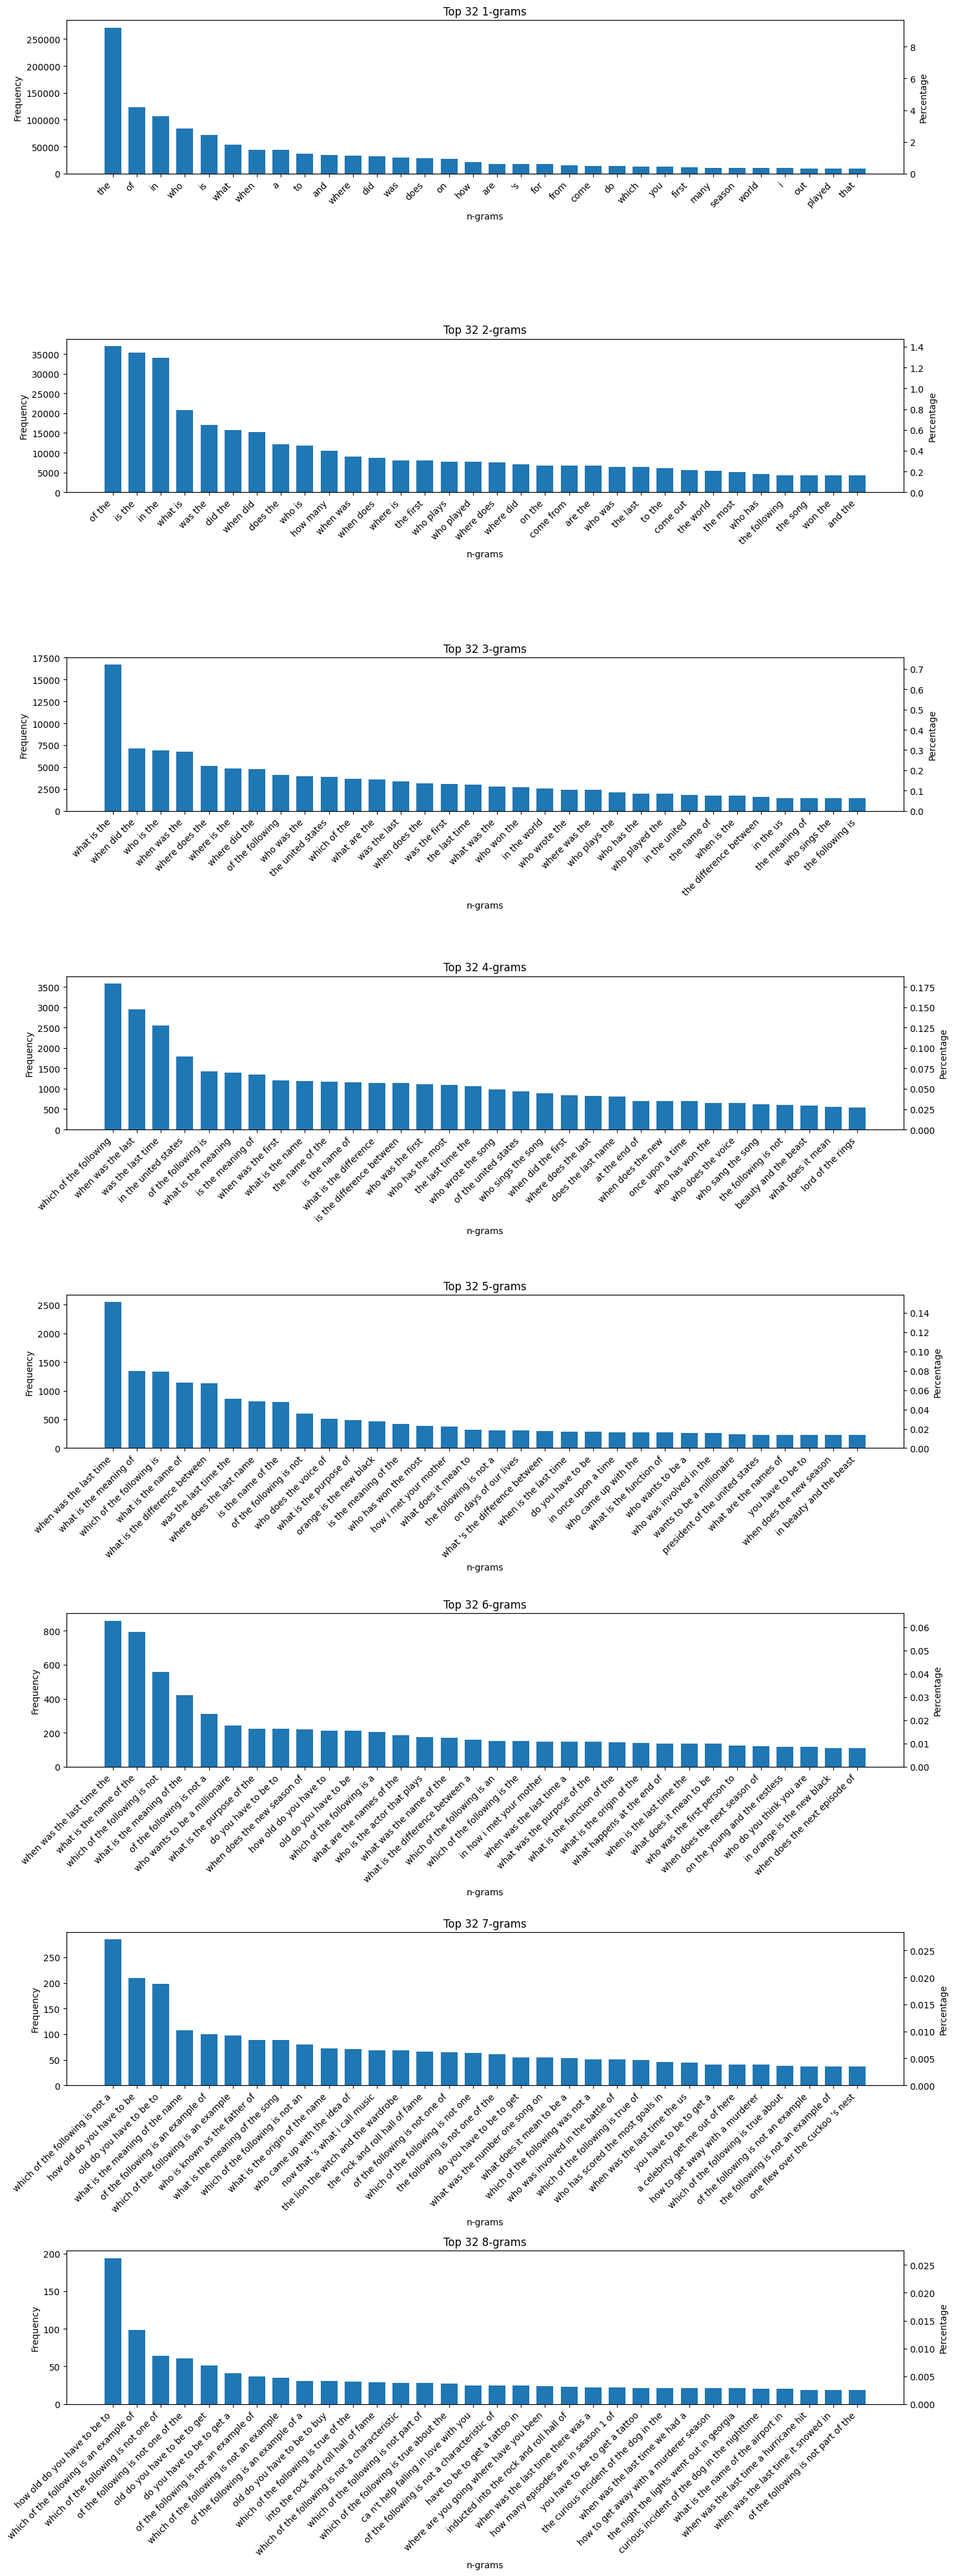

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df_ngram = pd.read_csv('top_ngrams.csv', index_col=0)

def parse_ngram_freq(cell):
    if isinstance(cell, str):
        ngram, freq, ratio = eval(cell)
        return ngram, freq, ratio
    return None, 0, 0

fig, axs = plt.subplots(8, 1, figsize=(15, 40))

for i in range(8):
    n = i + 1
    ngram_labels = []
    frequencies = []
    percentages = []

    
    for col in df_ngram.columns:
        ngram, freq, ratio = parse_ngram_freq(df_ngram.at[f'{n}-gram', col])
        if ngram:
            ngram_labels.append(ngram)
            frequencies.append(freq)
            percentages.append(ratio * 100)
    
    ax1 = axs[i]
    bar_width = 0.7
    x = range(len(ngram_labels))
    
    ax1.bar(x, frequencies, bar_width, label='Frequency')
    ax1.set_title(f'Top 32 {n}-grams')
    ax1.set_xlabel('n-grams')
    ax1.set_ylabel('Frequency')
    ax1.set_xticks(x)
    ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
    
    ax2 = ax1.twinx()
    ax2.bar(x, percentages, bar_width, label='Percentage')
    ax2.set_ylabel('Percentage')
    
plt.tight_layout()
plt.show()

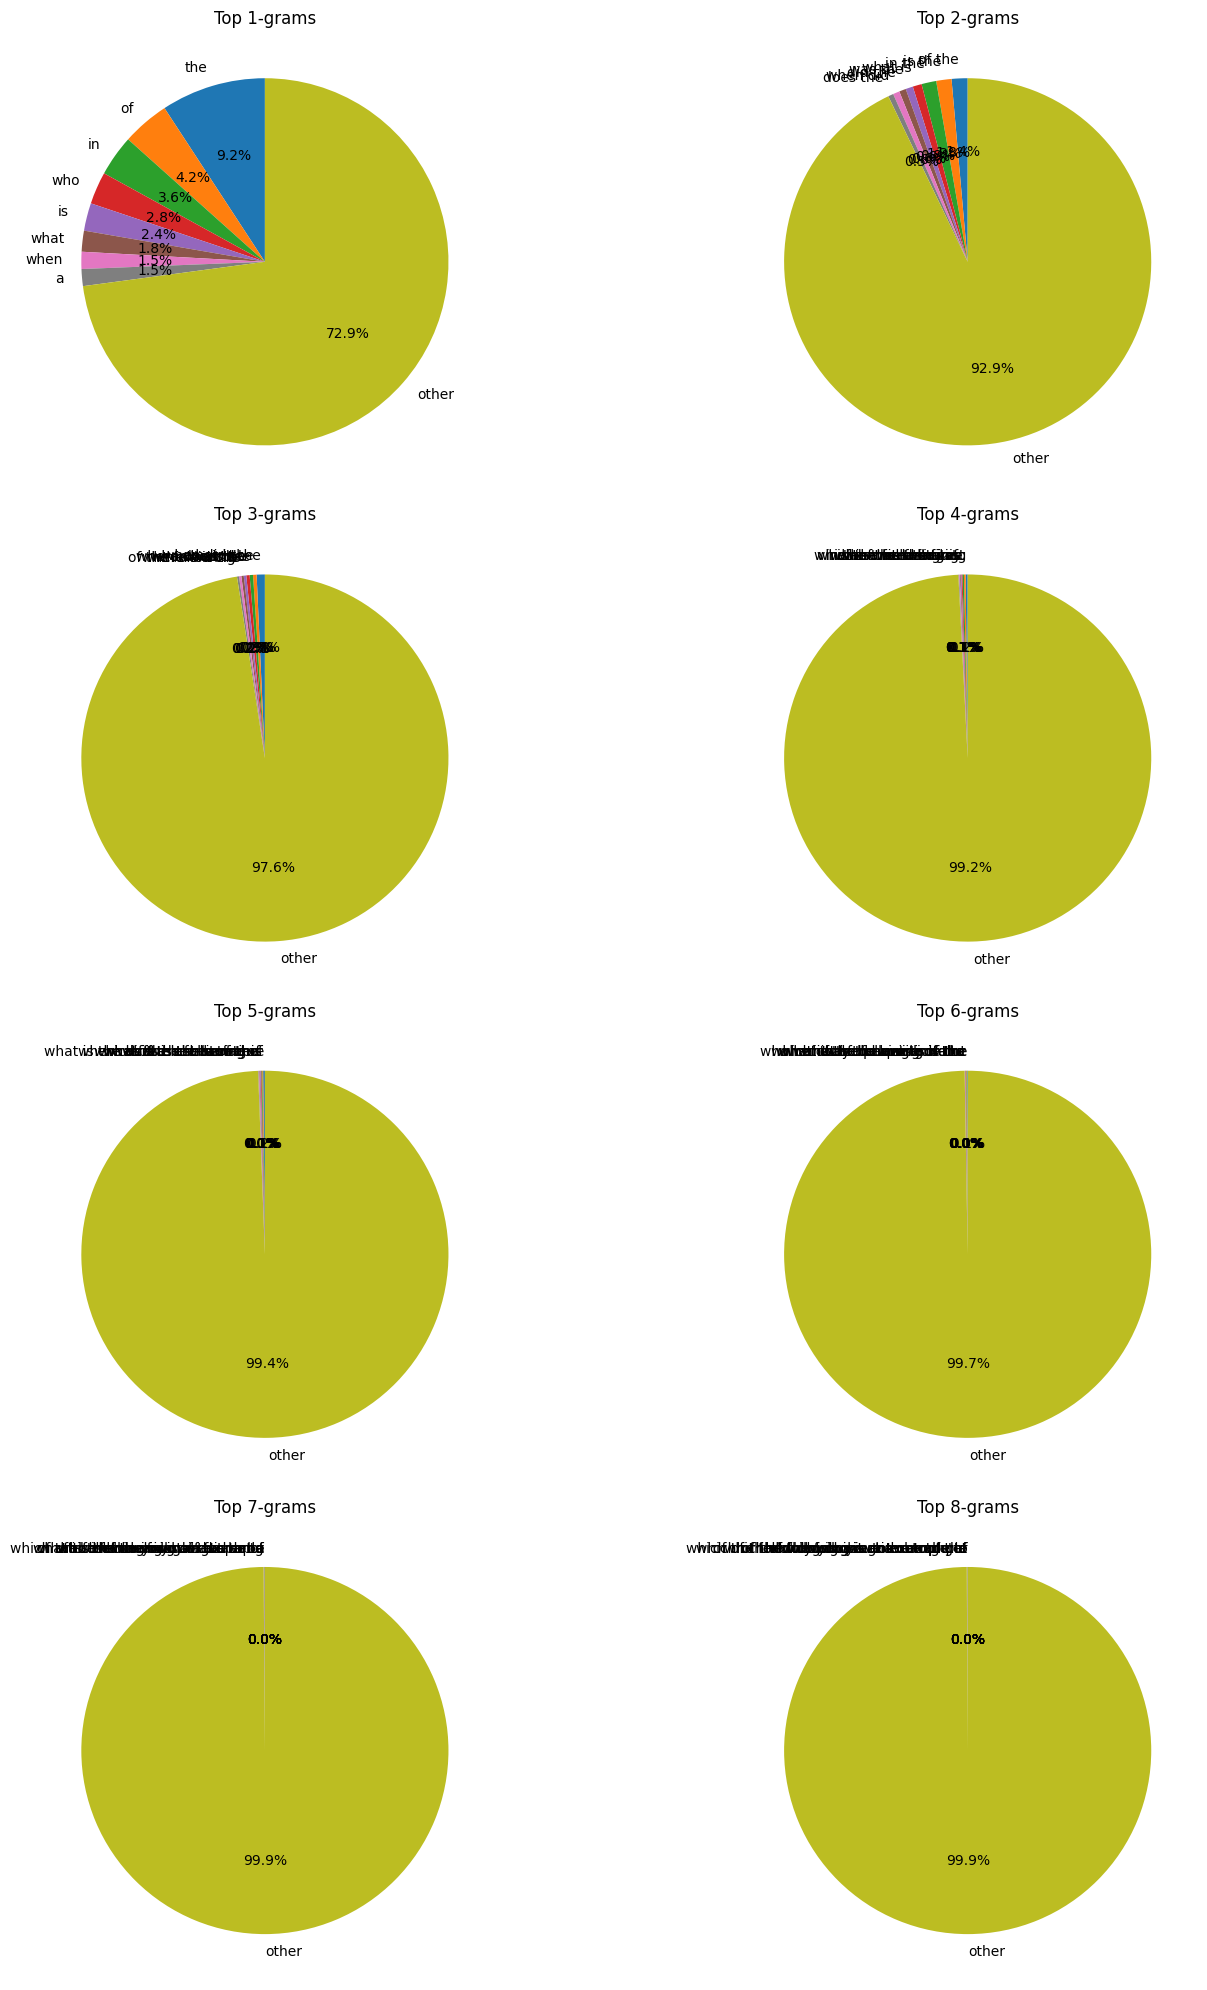

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df_ngram = pd.read_csv('top_ngrams.csv', index_col=0)

def parse_ngram_freq(cell):
    if isinstance(cell, str):
        ngram, freq, ratio = eval(cell)
        return ngram, freq, ratio
    return None, 0, 0

def create_pie_chart(ax, n, ngram_labels, ratios):
    sorted_indices = sorted(range(len(ratios)), key=lambda i: ratios[i], reverse=True)
    sorted_labels = [ngram_labels[i] for i in sorted_indices]
    sorted_ratios = [ratios[i] for i in sorted_indices]
    
    top_8_labels = sorted_labels[:8]
    top_8_ratios = sorted_ratios[:8]
    other_ratio = 100 - sum(top_8_ratios)
    top_8_labels.append('other')
    top_8_ratios.append(other_ratio)
    
    ax.pie(top_8_ratios, labels=top_8_labels, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Top {n}-grams')

fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.flatten()

for i in range(8):
    n = i + 1
    ngram_labels = []
    frequencies = []
    percentages = []
    
    for col in df_ngram.columns:
        ngram, freq, ratio = parse_ngram_freq(df_ngram.at[f'{n}-gram', col])
        if ngram:
            ngram_labels.append(ngram)
            frequencies.append(freq)
            percentages.append(ratio * 100)

    total_freq = sum(frequencies)
    create_pie_chart(axs[i], n, ngram_labels, percentages)
    
plt.tight_layout()
plt.show()
